In [59]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import r2_score

import yfinance as yf
from pandas_datareader import data as pdr
import datetime as dt

sns.set( rc={'figure.figsize':(16,9)} )

# Choose stocks and market

In [60]:
chosen_ones = [
                'Titan', 'ASIANPAINT',      # Consumer Durables
                'HINDUNILVR', 'ITC',        # FMCG
                'APOLLOHOSP',               # Healthcare
                'HDFCBANK', 'HDFC'          # Financial Services
            ]

index_one = '^NSEI'                         # NIFTY 50

# Download data

In [61]:
history = {}

yf.pdr_override( )
history[index_one] = pdr.get_data_yahoo( index_one, period='3y' ).reset_index( )

good_dates = set( history[index_one]['Date'] )

history[index_one].shape

[*********************100%***********************]  1 of 1 completed


(746, 7)

In [62]:
for ticker in chosen_ones:
    history[ticker] = pdr.get_data_yahoo( ticker + '.NS', period='3y' ).reset_index( )
    print( ticker + ': ' + str( history[ticker].shape ) )

    good_dates = good_dates.intersection( set( history[ticker]['Date'] ) )

[*********************100%***********************]  1 of 1 completed
Titan: (748, 7)
[*********************100%***********************]  1 of 1 completed
ASIANPAINT: (748, 7)
[*********************100%***********************]  1 of 1 completed
HINDUNILVR: (748, 7)
[*********************100%***********************]  1 of 1 completed
ITC: (748, 7)
[*********************100%***********************]  1 of 1 completed
APOLLOHOSP: (748, 7)
[*********************100%***********************]  1 of 1 completed
HDFCBANK: (748, 7)
[*********************100%***********************]  1 of 1 completed
HDFC: (748, 7)


# Get rid of dates with missing data

In [63]:
for key in history.keys( ):
    history[key] = history[key][ history[key]['Date'].isin( good_dates ) ].reset_index( drop=True )
    print( key + ': ' + str( history[key].shape ) )

^NSEI: (746, 7)
Titan: (746, 7)
ASIANPAINT: (746, 7)
HINDUNILVR: (746, 7)
ITC: (746, 7)
APOLLOHOSP: (746, 7)
HDFCBANK: (746, 7)
HDFC: (746, 7)


# Calculate Daily Return

In [64]:
for key in history.keys( ):
    history[key]['Return'] = ( history[key]['Close'] - history[key]['Close'].shift( 1 ) ) / history[key]['Close'].shift( 1 )
    history[key].dropna( inplace=True )
    history[key].reset_index ( drop=True, inplace=True )

# Train test split

In [65]:
split_date = history[index_one]['Date'].max( ) - dt.timedelta( days=180 )
split_date

Timestamp('2022-04-17 00:00:00+0530', tz='Asia/Kolkata')

In [66]:
test_history = {}
train_history = {}

for key in history.keys( ):
    train_history[key] = history[key][ history[key]['Date'] < split_date ].copy( )
    test_history[key] = history[key][ history[key]['Date'] >= split_date ].copy( )

# Calculate Expected Return and Standard Deviation

In [67]:
train_exp_return = {}
train_std_return = {}

for key in train_history.keys( ):
    train_exp_return[key] = train_history[key]['Return'].mean( )
    train_std_return[key] = train_history[key]['Return'].std( )

In [68]:
test_exp_return = {}
test_std_return = {}

for key in test_history.keys( ):
    test_exp_return[key] = test_history[key]['Return'].mean( )
    test_std_return[key] = test_history[key]['Return'].std( )

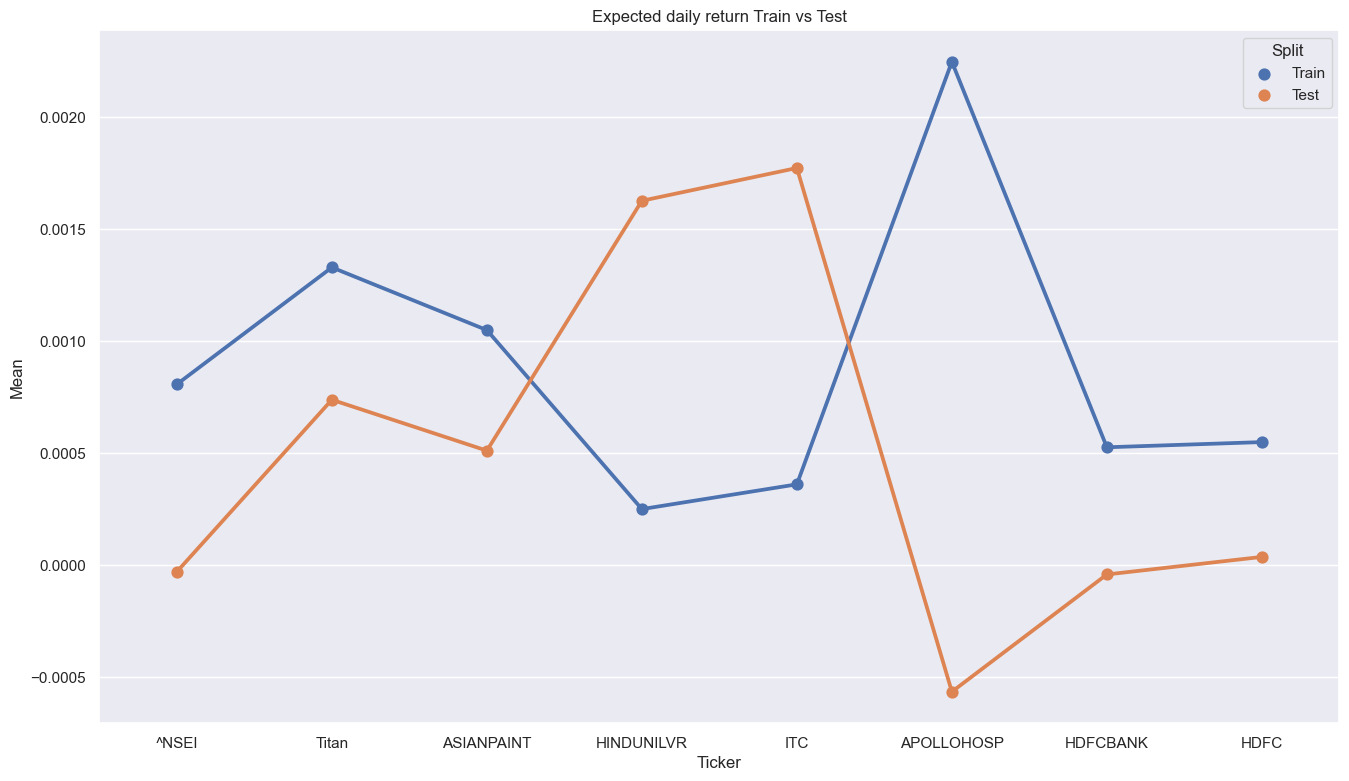

In [69]:
exp_return_graph = pd.concat( [
pd.DataFrame( list( zip( ['Train'] * len( train_exp_return.keys( ) ), train_exp_return.keys( ), train_exp_return.values( ) ) ), columns=['Split', 'Ticker', 'Mean'] ),
pd.DataFrame( list( zip( ['Test'] * len( test_exp_return.keys( ) ), test_exp_return.keys( ), test_exp_return.values( ) ) ), columns=['Split', 'Ticker', 'Mean'] )
] )

fig = sns.pointplot( data=exp_return_graph, x='Ticker', y='Mean', hue='Split' )
plt.title( 'Expected daily return Train vs Test' )
plt.show( )

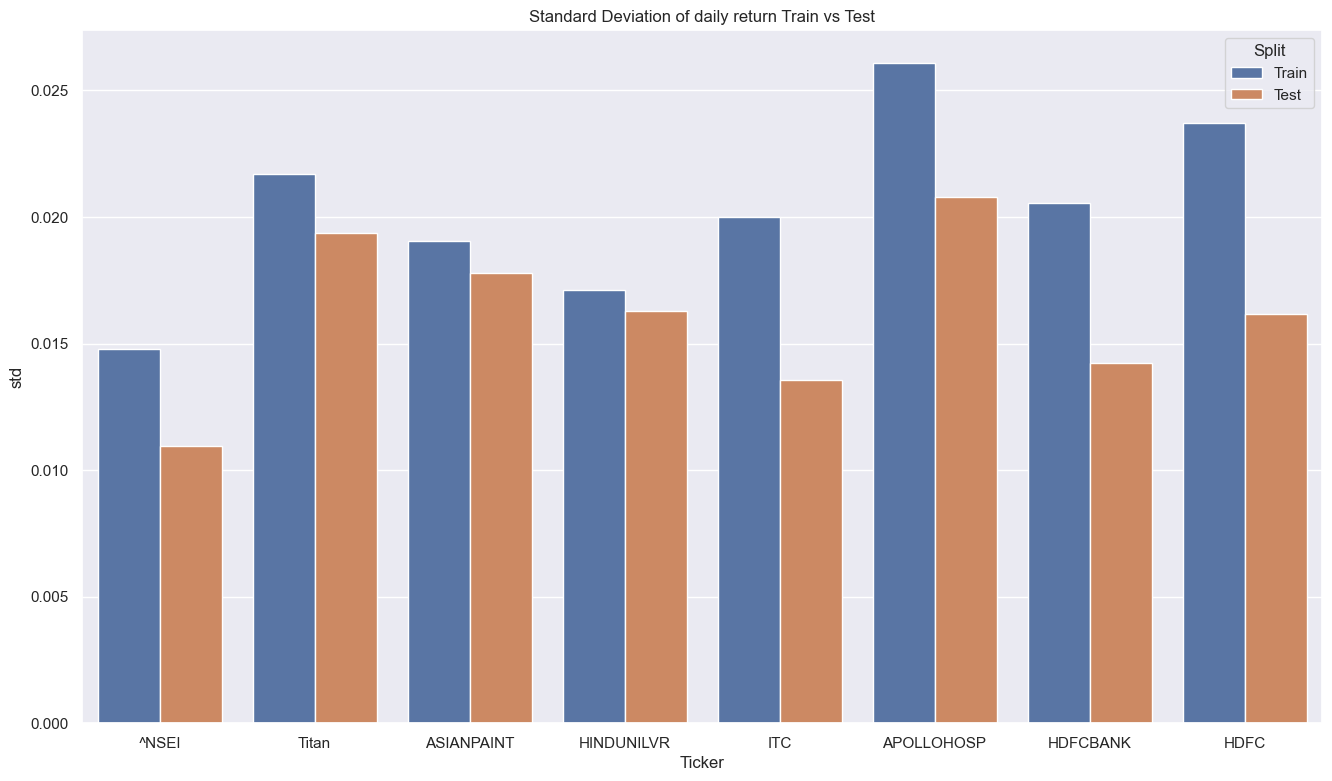

In [70]:
std_return_graph = pd.concat( [
pd.DataFrame( list( zip( ['Train'] * len( train_std_return.keys( ) ), train_std_return.keys( ), train_std_return.values( ) ) ), columns=['Split', 'Ticker', 'std'] ),
pd.DataFrame( list( zip( ['Test'] * len( test_std_return.keys( ) ), test_std_return.keys( ), test_std_return.values( ) ) ), columns=['Split', 'Ticker', 'std'] )
] )

# fig = sns.pointplot( data=std_return_graph, x='Ticker', y='std', hue='Split' )
sns.barplot( data=std_return_graph, x='Ticker', y='std', hue='Split' )
plt.title( 'Standard Deviation of daily return Train vs Test' )
plt.show( )

#### Expected return seems to vary alot between train and test data - standard deviation is similar between train and test data

# Calculate correlation coefficient for each stock with market

In [71]:
corr_coeff = {}

for stock in chosen_ones:
    corr_coeff[stock] = np.corrcoef( train_history[stock]['Return'], train_history[index_one]['Return'] )[0,1]

In [72]:
corr_coeff

{'Titan': 0.6143851863935726,
 'ASIANPAINT': 0.5468101607608377,
 'HINDUNILVR': 0.508318671667921,
 'ITC': 0.5270183802330024,
 'APOLLOHOSP': 0.420858883661161,
 'HDFCBANK': 0.7938223840054546,
 'HDFC': 0.7928376756625372}

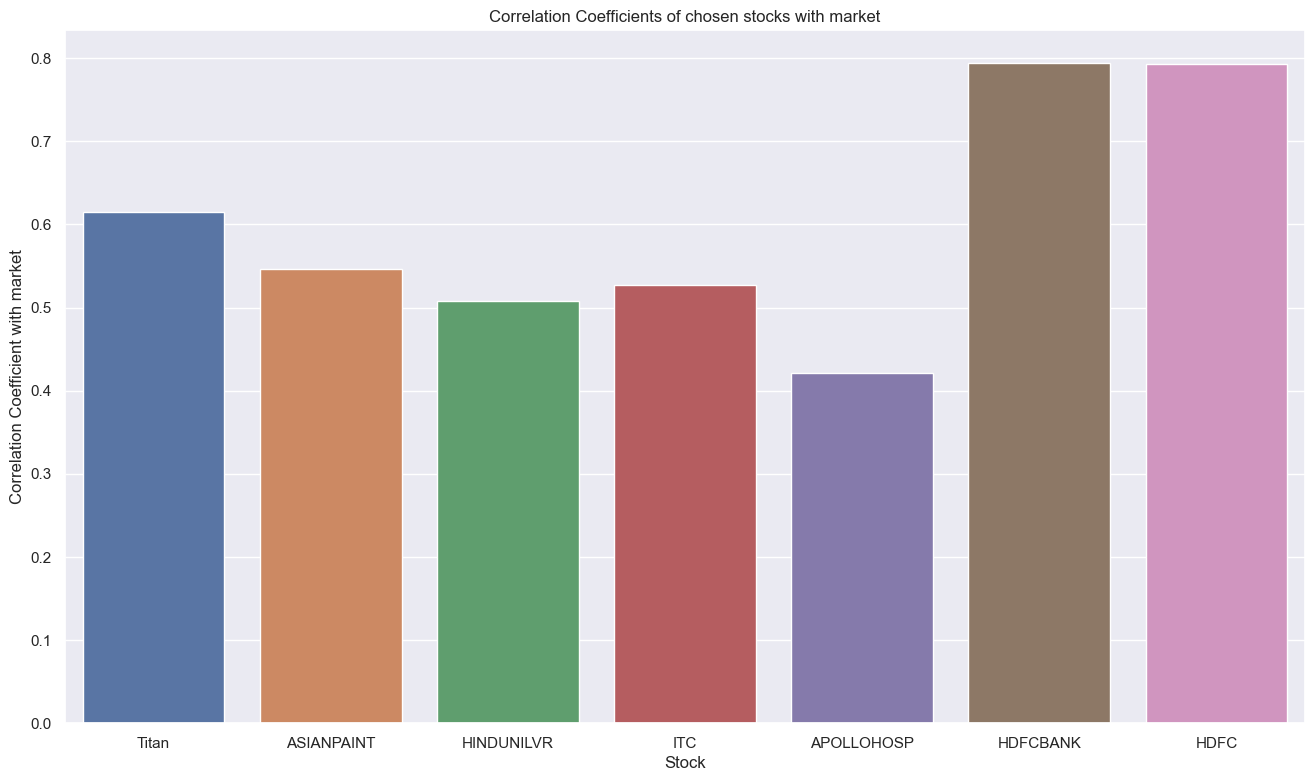

In [73]:
sns.barplot( x=list( corr_coeff.keys( ) ), y=list( corr_coeff.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'Correlation Coefficient with market' )
plt.title( 'Correlation Coefficients of chosen stocks with market' )
plt.show( )

# Calculate Beta for each stock

In [74]:
beta = {}

for stock in chosen_ones:
    beta[stock] = corr_coeff[stock] * train_std_return[stock] / train_std_return[index_one]

In [75]:
beta

{'Titan': 0.9027727450447478,
 'ASIANPAINT': 0.704890713881165,
 'HINDUNILVR': 0.5888535940195077,
 'ITC': 0.7131638014525068,
 'APOLLOHOSP': 0.7426805011761544,
 'HDFCBANK': 1.1032313127883173,
 'HDFC': 1.2732714666211744}

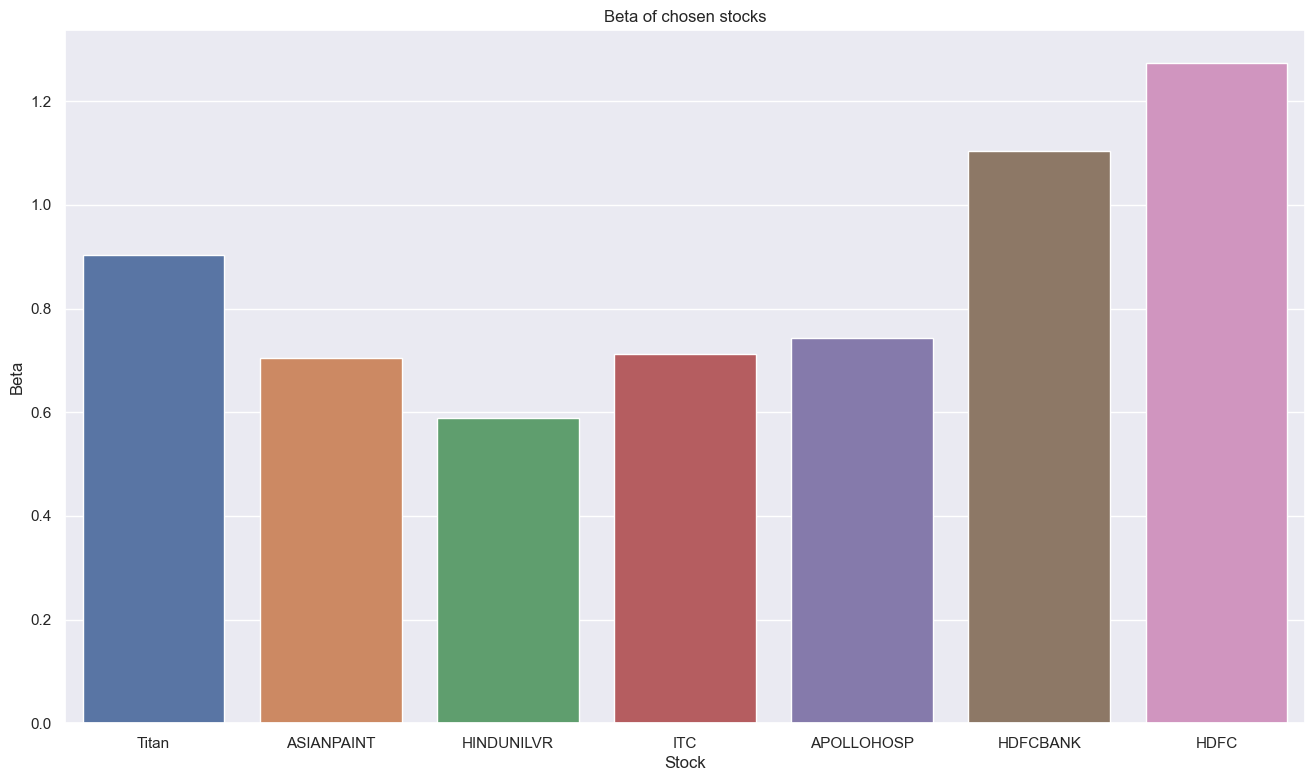

In [76]:
sns.barplot( x=list( beta.keys( ) ), y=list( beta.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'Beta' )
plt.title( 'Beta of chosen stocks' )
plt.show( )

# Calculate R2 Score for each stock

In [77]:
r2 = {}

for stock in chosen_ones:
    r2[stock] = r2_score( train_history[stock]['Return'], train_history[index_one]['Return'] )

In [78]:
r2

{'Titan': 0.37251206447537677,
 'ASIANPAINT': 0.24643199490583656,
 'HINDUNILVR': 0.1313605201670257,
 'ITC': 0.23231748636605098,
 'APOLLOHOSP': 0.1528030886157027,
 'HDFCBANK': 0.6244484849245712,
 'HDFC': 0.5995185688298935}

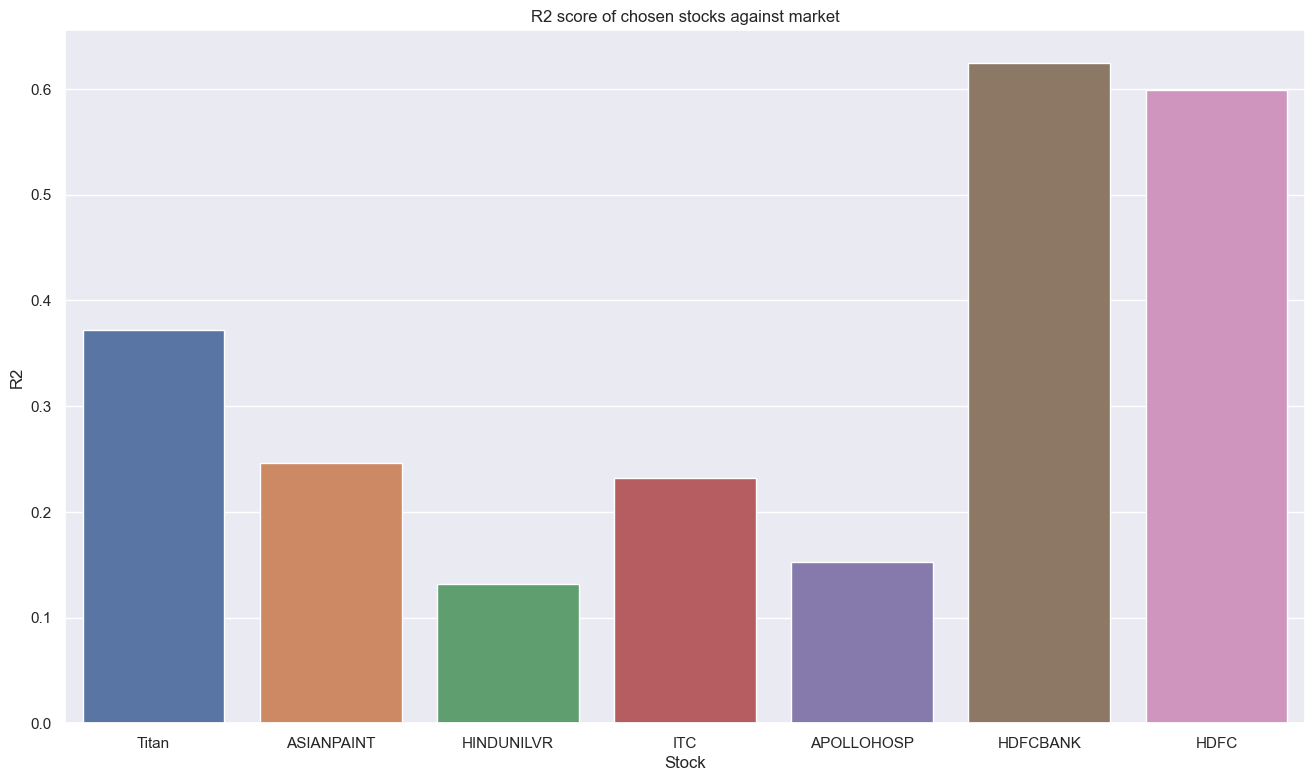

In [79]:
sns.barplot( x=list( r2.keys( ) ), y=list( r2.values( ) ) )
plt.xlabel( 'Stock' )
plt.ylabel( 'R2' )
plt.title( 'R2 score of chosen stocks against market' )
plt.show( )

# Summary graph

In [80]:
summary_df = pd.merge( 
                        pd.DataFrame( zip( r2.keys( ), r2.values( ) ), columns=['Stock', 'R2'] ),
                        pd.DataFrame( zip( beta.keys( ), beta.values( ) ), columns=['Stock', 'Beta'] ),
                        on=['Stock']
                    )

summary_df = summary_df.merge( pd.DataFrame( zip( corr_coeff.keys( ), corr_coeff.values( ) ), columns=['Stock', 'CorrCoeff'] ), on=['Stock'] )

summary_df = summary_df.merge( pd.DataFrame( zip( train_std_return.keys( ), train_std_return.values( ) ), columns=['Stock', 'std'] ), on=['Stock'] )

summary_df.head( 10 )

,Stock,R2,Beta,CorrCoeff,std
0,Titan,0.372512,0.902773,0.614385,0.021708
1,ASIANPAINT,0.246432,0.704891,0.546810,0.019045
2,HINDUNILVR,0.131361,0.588854,0.508319,0.017114
3,ITC,0.232317,0.713164,0.527018,0.019992
4,APOLLOHOSP,0.152803,0.742681,0.420859,0.026071
5,HDFCBANK,0.624448,1.103231,0.793822,0.020532
6,HDFC,0.599519,1.273271,0.792838,0.023726


In [81]:
graph_df = summary_df.melt( id_vars=['Stock'], value_vars=['R2', 'Beta', 'CorrCoeff', 'std'], var_name='Metric', value_name='Value' )
graph_df.head( )

,Stock,Metric,Value
0,Titan,R2,0.372512
1,ASIANPAINT,R2,0.246432
2,HINDUNILVR,R2,0.131361
3,ITC,R2,0.232317
4,APOLLOHOSP,R2,0.152803


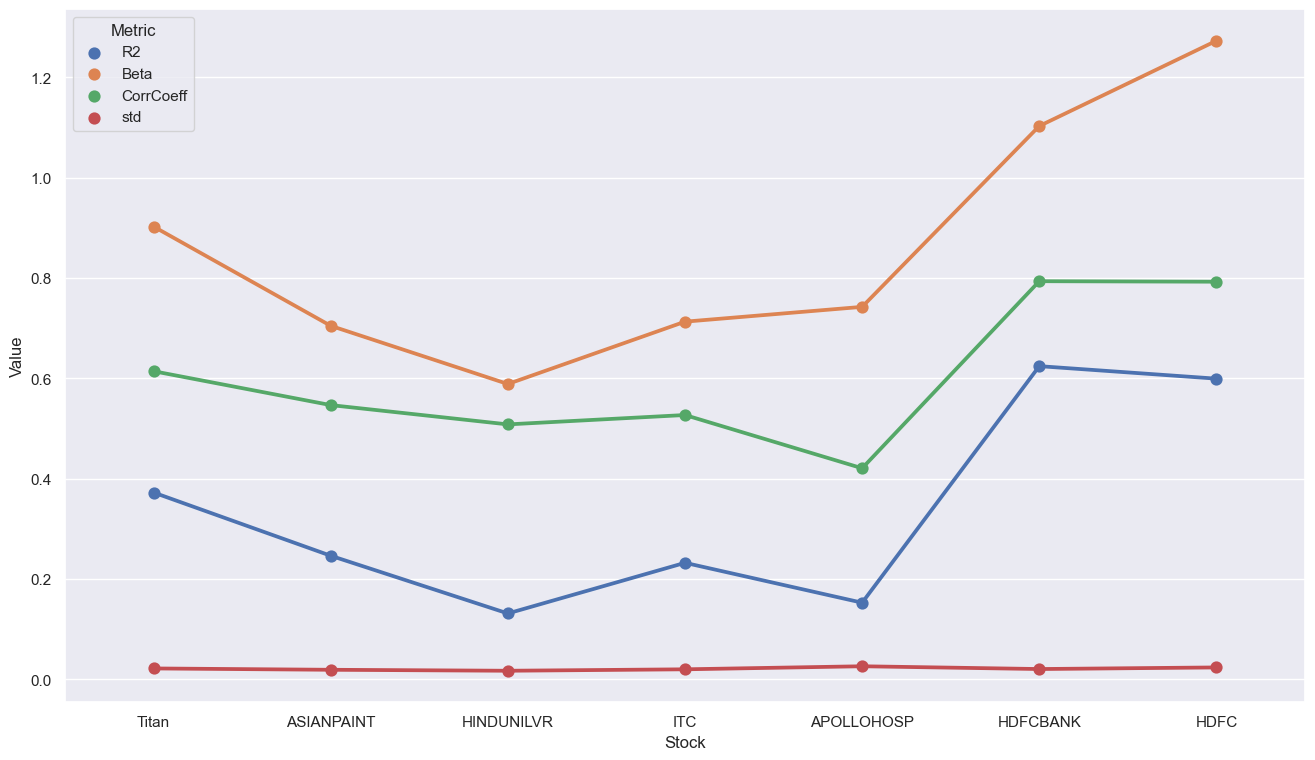

In [82]:
sns.pointplot( data=graph_df, x='Stock', y='Value', hue='Metric' )
plt.show( )

#### Low beta stocks have low correlation to market and low standard deviations - the opposite is true for high beta stocks

# Covariance Matrix

In [83]:
returns_df = pd.DataFrame( )

for stock in chosen_ones:
    returns_df[stock] = train_history[stock]['Return']

print( returns_df.shape )
returns_df.head( )

(620, 7)


,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
0,0.018536,0.002446,0.024898,0.014338,0.022042,0.015485,-0.000720
1,0.001926,-0.020742,0.003197,-0.015953,-0.000371,-0.001594,0.017583
2,0.001961,0.026392,0.015862,0.009029,0.002764,-0.000901,0.020037
3,0.018441,0.002455,0.001426,0.002644,0.013817,0.007377,0.002249
4,0.022182,-0.020118,0.009730,0.009736,0.007660,0.008381,0.009764


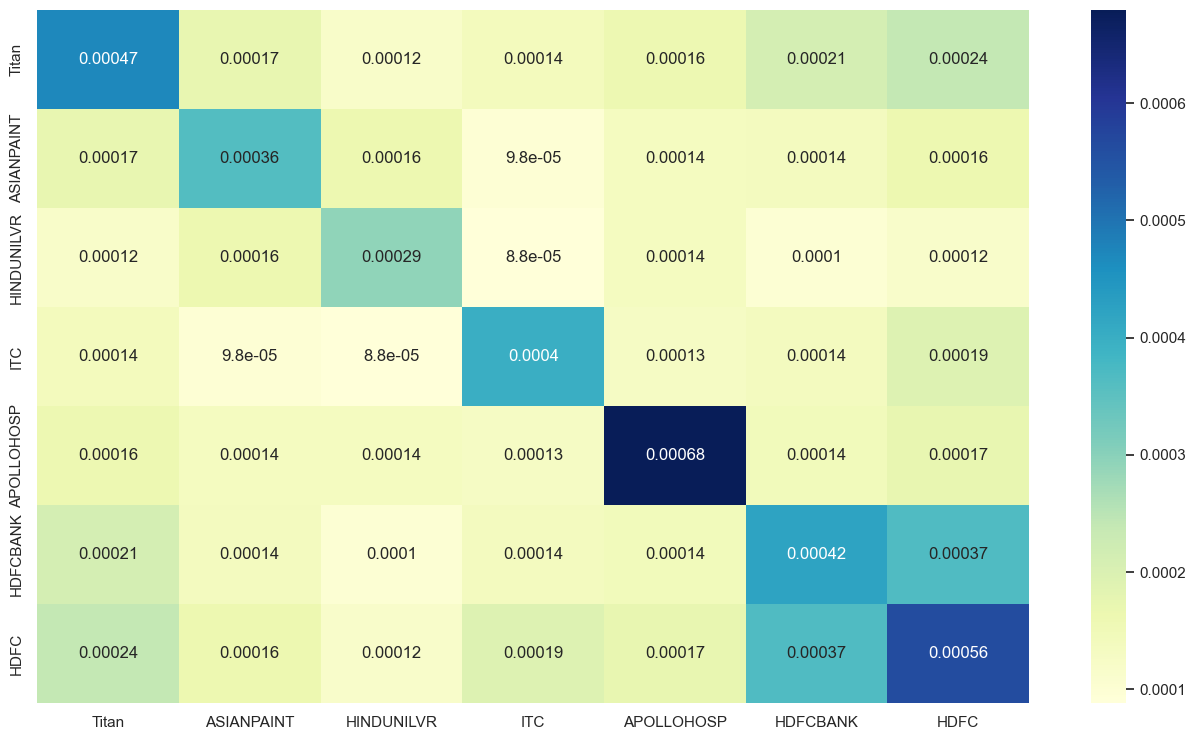

In [84]:
covar_df = returns_df.cov( )

sns.heatmap( covar_df, xticklabels=covar_df.columns, yticklabels=covar_df.columns, cmap='YlGnBu', annot=True )
plt.show( )

# Plotting Efficient Frontier

#### To plot efficient frontier - first we take a big number of portfolios with randomised stock weights (which always add up to 1) and record the standard deviation/return for each portfolio, then we plot the portfolios with maximum return for fixed standard deviations

In [85]:
graph_weights = []
graph_returns = []
graph_std = []


for iteration in range( 10000 ):
    # Generate random weights
    weights = np.random.random( len( chosen_ones ) )

    # Make sure weights add up to 1
    weights = weights / np.sum( weights )
    graph_weights.append( weights )

    # Calculate expected returns for this iteration
    returns = np.dot( weights, [ train_exp_return[stock] for stock in chosen_ones ] )
    graph_returns.append( returns )

    # Calculate standard deviation for this iteration
    std = np.sqrt( covar_df.mul( weights, axis=0 ).mul( weights, axis=1 ).sum( ).sum( ) )
    graph_std.append( std )

In [86]:
graph_df = pd.DataFrame( )

graph_df['Return'] = graph_returns
graph_df['std'] = graph_std

for idx, stock in enumerate( chosen_ones ):
    graph_df[stock] = np.asarray( graph_weights )[:,idx]

graph_df.head( )

,Return,std,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
0,0.000997,0.014947,0.053540,0.174496,0.187152,0.005183,0.222742,0.158728,0.198159
1,0.001188,0.014779,0.188641,0.145013,0.040040,0.218913,0.279219,0.113440,0.014735
2,0.000869,0.014705,0.173507,0.072797,0.104067,0.192065,0.128387,0.133551,0.195627
3,0.000781,0.014891,0.122081,0.301048,0.123987,0.041792,0.020539,0.212052,0.178501
4,0.000717,0.014482,0.230986,0.114991,0.213226,0.098875,0.009321,0.187702,0.144900


In [87]:
frontier_df = pd.DataFrame( )
tol = 1e-4

for std in graph_df['std'].unique( ):
    # Get maximum/minimum return for current standard deviation
    if len( graph_df[ np.abs(graph_df['std'] - std)<=tol ] ) < 10:
        continue

    max_index = graph_df[ np.abs(graph_df['std'] - std)<=tol ]['Return'].idxmax( )
    # min_index = graph_df[ np.abs(graph_df['std'] - std)<=tol ]['Return'].idxmin( )

    frontier_df = pd.concat( [
                                frontier_df, 
                                graph_df.iloc[max_index:max_index+1,:], 
                                # graph_df.iloc[min_index:min_index+1,:]
                            ], ignore_index=True )

print( frontier_df.shape )
frontier_df.head( )

(9974, 9)


,Return,std,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
0,0.001288,0.015042,0.125920,0.305414,0.071402,0.087721,0.310001,0.075888,0.023655
1,0.001253,0.014803,0.187496,0.336826,0.029966,0.153901,0.251151,0.031801,0.008859
2,0.001253,0.014803,0.187496,0.336826,0.029966,0.153901,0.251151,0.031801,0.008859
3,0.001260,0.014981,0.243804,0.145578,0.171472,0.115344,0.306192,0.000943,0.016667
4,0.001201,0.014566,0.196998,0.254015,0.085040,0.146454,0.249414,0.032259,0.035821


In [88]:
# Get the tip of efficient frontier
min_index = np.argmin( graph_df['std'] )

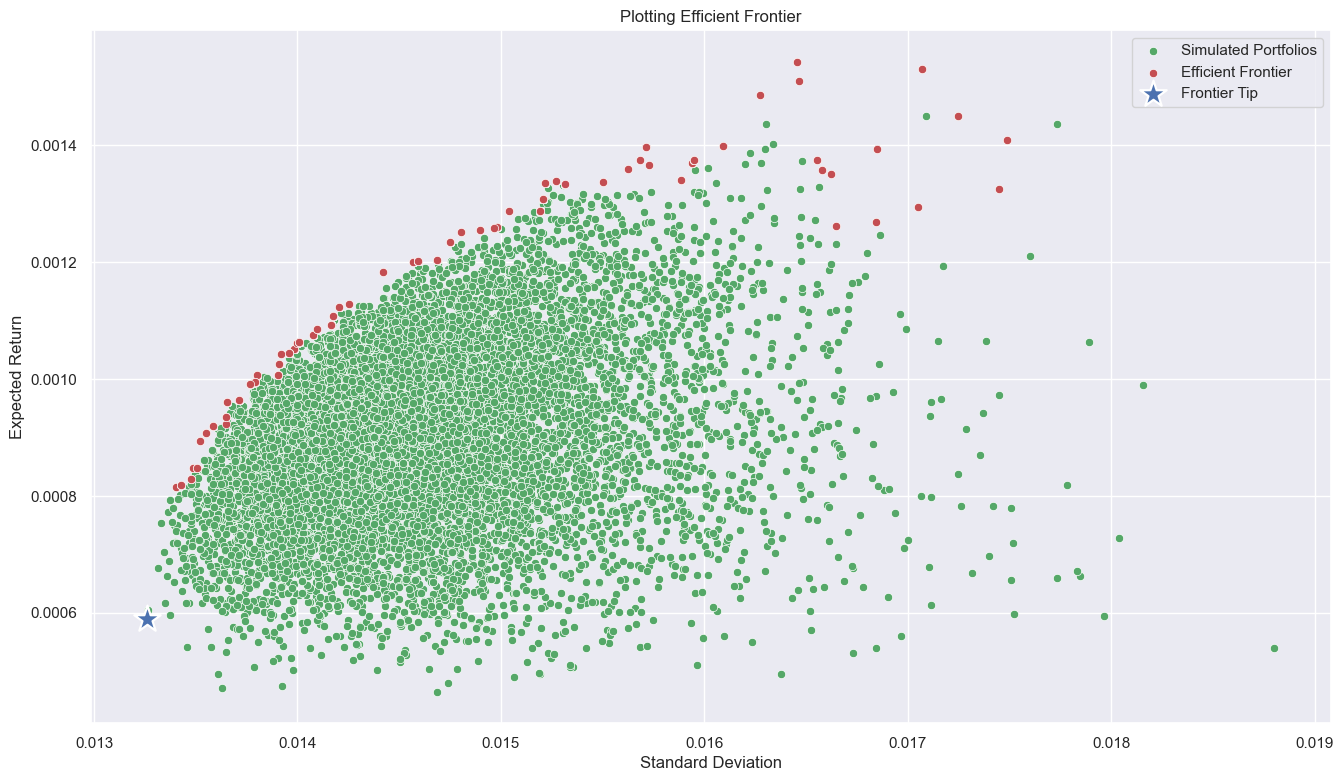

In [89]:
# Plot iteration outcome
sns.scatterplot( x=graph_df['std'], y=graph_df['Return'], marker='o', color='g', label='Simulated Portfolios' )

# Plot efficient frontier (and tip)
sns.scatterplot( x=frontier_df['std'], y=frontier_df['Return'], color='r', label='Efficient Frontier' )
sns.scatterplot( x=[graph_std[ min_index ]], y=[graph_returns[ min_index ]], marker='*', color='b', s=400, label='Frontier Tip'  )

plt.xlabel( 'Standard Deviation' )
plt.ylabel( 'Expected Return' )
plt.title( 'Plotting Efficient Frontier' )

plt.show( )

# My efficient portfolio

In [90]:
risk_factor = 0.0155

In [91]:
max_index = graph_df[ np.abs(graph_df['std'] - risk_factor)<=tol ]['Return'].idxmax( )

efficient_df = graph_df.iloc[max_index:max_index+1,:]

print( efficient_df.shape )
efficient_df.head( )

(1, 9)


,Return,std,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC
2645,0.001337,0.015501,0.242636,0.188487,0.136903,0.009043,0.322138,0.034163,0.066631


In [92]:
efficient_weights = list( efficient_df[chosen_ones].iloc[0] )
efficient_weights

[0.24263616707254312,
 0.18848686127354747,
 0.13690263912232598,
 0.009042895671744742,
 0.3221377091844561,
 0.034163040746375634,
 0.0666306869290068]

In [93]:
train_simulation = pd.DataFrame( )
test_simulation = pd.DataFrame( )

for stock in chosen_ones:
    train_simulation[stock] = train_history[stock]['Return']
    test_simulation[stock] = test_history[stock]['Return']

train_simulation['Return'] = train_simulation.dot( efficient_weights )
test_simulation['Return'] = test_simulation.dot( efficient_weights )

train_simulation['Date'] = train_history[stock]['Date']
test_simulation['Date'] = test_history[stock]['Date']

print( train_simulation.shape )
print( test_simulation.shape )
train_simulation.head( )

(620, 9)
(125, 9)


,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC,Return,Date
0,0.018536,0.002446,0.024898,0.014338,0.022042,0.015485,-0.000720,0.016078,2019-10-15 00:00:00+05:30
1,0.001926,-0.020742,0.003197,-0.015953,-0.000371,-0.001594,0.017583,-0.002151,2019-10-16 00:00:00+05:30
2,0.001961,0.026392,0.015862,0.009029,0.002764,-0.000901,0.020037,0.009898,2019-10-17 00:00:00+05:30
3,0.018441,0.002455,0.001426,0.002644,0.013817,0.007377,0.002249,0.010009,2019-10-18 00:00:00+05:30
4,0.022182,-0.020118,0.009730,0.009736,0.007660,0.008381,0.009764,0.006415,2019-10-22 00:00:00+05:30


In [94]:
print( 'Efficient Portfolio expected daily return in train period = ', train_simulation['Return'].mean( ) )
print( 'Market expected daily return in train period = ', train_history[index_one]['Return'].mean( ) )

print( )

print( 'Efficient Portfolio expected daily return in test period = ', test_simulation['Return'].mean( ) )
print( 'Market expected daily return in test period = ', test_history[index_one]['Return'].mean( ) )

Efficient Portfolio expected daily return in train period =  0.0013372607609947382
Market expected daily return in train period =  0.0008082463916586399

Efficient Portfolio expected daily return in test period =  0.00033386088516448495
Market expected daily return in test period =  -2.8818220692242158e-05


In [95]:
train_simulation['cumprod'] = ( train_simulation['Return'] + 1 ).cumprod( )
train_simulation['market_cumprod'] = ( train_history[index_one]['Return'] + 1 ).cumprod( )

test_simulation['cumprod'] = ( test_simulation['Return'] + 1 ).cumprod( )
test_simulation['market_cumprod'] = ( test_history[index_one]['Return'] + 1 ).cumprod( )

In [96]:
train_simulation.head( )

,Titan,ASIANPAINT,HINDUNILVR,ITC,APOLLOHOSP,HDFCBANK,HDFC,Return,Date,cumprod,market_cumprod
0,0.018536,0.002446,0.024898,0.014338,0.022042,0.015485,-0.000720,0.016078,2019-10-15 00:00:00+05:30,1.016078,1.007684
1,0.001926,-0.020742,0.003197,-0.015953,-0.000371,-0.001594,0.017583,-0.002151,2019-10-16 00:00:00+05:30,1.013893,1.010832
2,0.001961,0.026392,0.015862,0.009029,0.002764,-0.000901,0.020037,0.009898,2019-10-17 00:00:00+05:30,1.023929,1.021620
3,0.018441,0.002455,0.001426,0.002644,0.013817,0.007377,0.002249,0.010009,2019-10-18 00:00:00+05:30,1.034177,1.028277
4,0.022182,-0.020118,0.009730,0.009736,0.007660,0.008381,0.009764,0.006415,2019-10-22 00:00:00+05:30,1.040811,1.021797


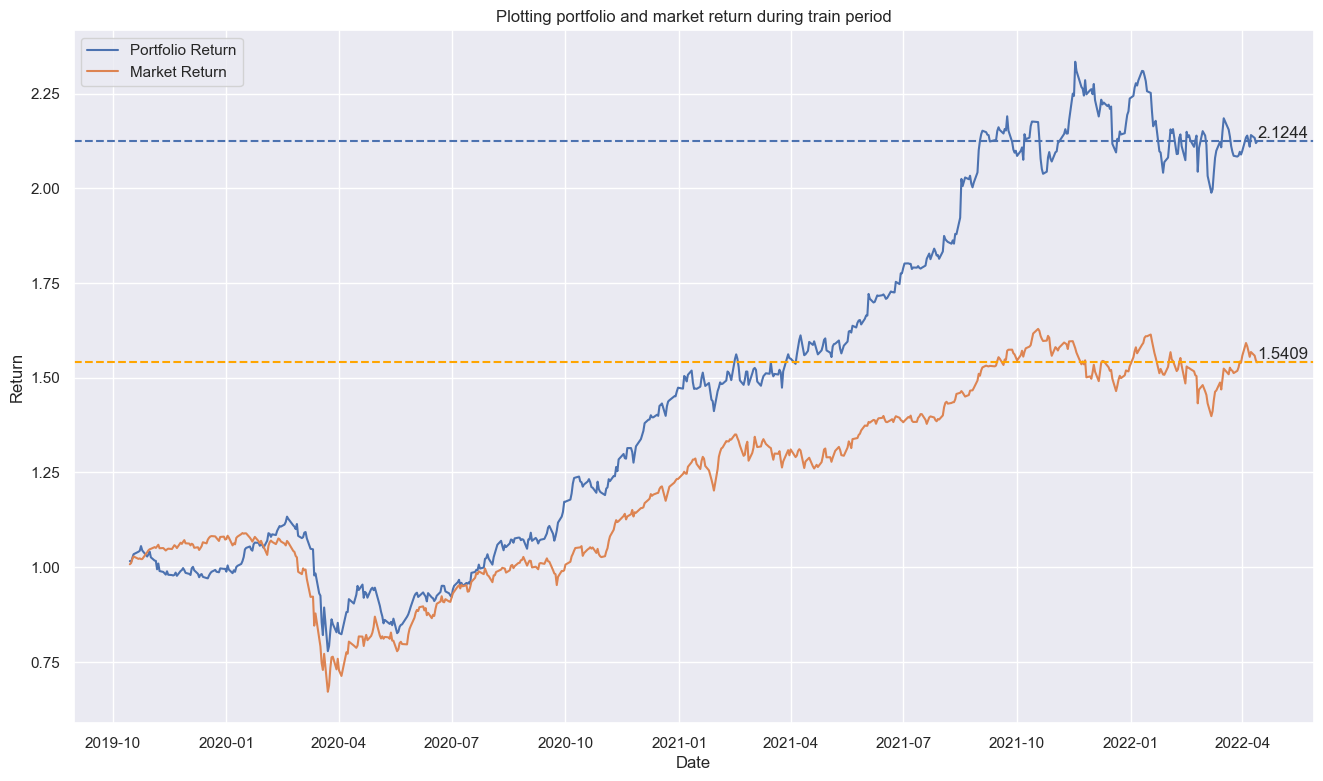

In [152]:
sns.lineplot( data=train_simulation, x='Date', y='cumprod', label='Portfolio Return' )
sns.lineplot( data=train_simulation, x='Date', y='market_cumprod', label='Market Return' )

plt.axhline( y=float( train_simulation[-1:]['cumprod'] ), linestyle='--', color='b' )
plt.text( 
            x=train_simulation['Date'].max( ) - dt.timedelta( days = 0), 
            y=float( train_simulation[-1:]['cumprod'] ) + 0.01, 
            s=str( round( float( train_simulation[-1:]['cumprod'] ), 4 ) )
        )

plt.axhline( y=float( train_simulation[-1:]['market_cumprod'] ), linestyle='--', color='orange' )
plt.text( 
            x=train_simulation['Date'].max( ) - dt.timedelta( days = 0), 
            y=float( train_simulation[-1:]['market_cumprod'] ) + 0.01, 
            s=str( round( float( train_simulation[-1:]['market_cumprod'] ), 4 ) ) 
        )

plt.ylabel( 'Return' )
plt.title( 'Plotting portfolio and market return during train period' )

plt.show( )

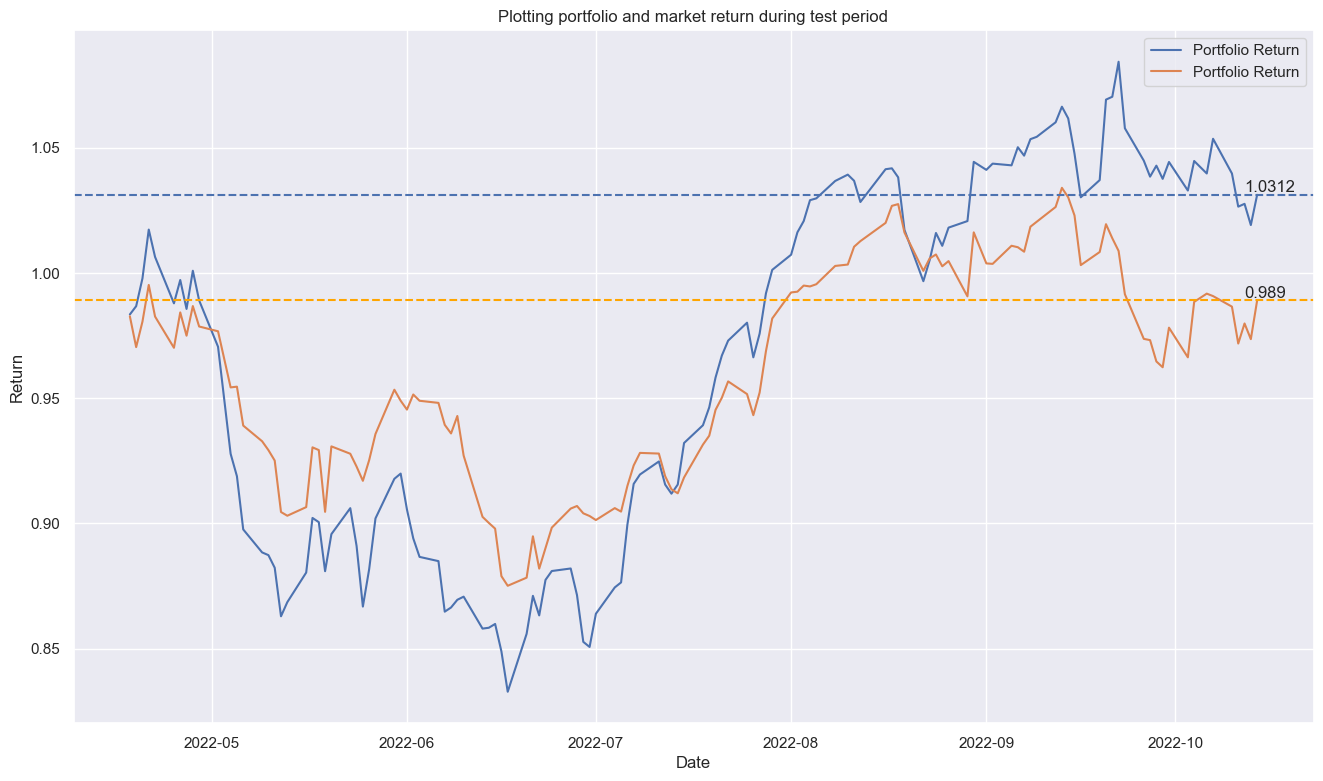

In [151]:
sns.lineplot( data=test_simulation, x='Date', y='cumprod', label='Portfolio Return' )
sns.lineplot( data=test_simulation, x='Date', y='market_cumprod', label='Portfolio Return' )

plt.axhline( y=float( test_simulation[-1:]['cumprod'] ), linestyle='--', color='b' )
plt.text( 
            x=test_simulation['Date'].max( ) - dt.timedelta( days = 2), 
            y=float( test_simulation[-1:]['cumprod'] ) + 0.001, 
            s=str( round( float( test_simulation[-1:]['cumprod'] ), 4 ) ) 
        )

plt.axhline( y=float( test_simulation[-1:]['market_cumprod'] ), linestyle='--', color='orange' )
plt.text( 
            x=test_simulation['Date'].max( ) - dt.timedelta( days = 2), 
            y=float( test_simulation[-1:]['market_cumprod'] ) + 0.001, 
            s=str( round( float( test_simulation[-1:]['market_cumprod'] ), 4 ) ) 
        )

plt.ylabel( 'Return' )
plt.title( 'Plotting portfolio and market return during test period' )

plt.show( )

In [126]:
test_simulation[-1:]['cumprod']

744    1.031219
Name: cumprod, dtype: float64

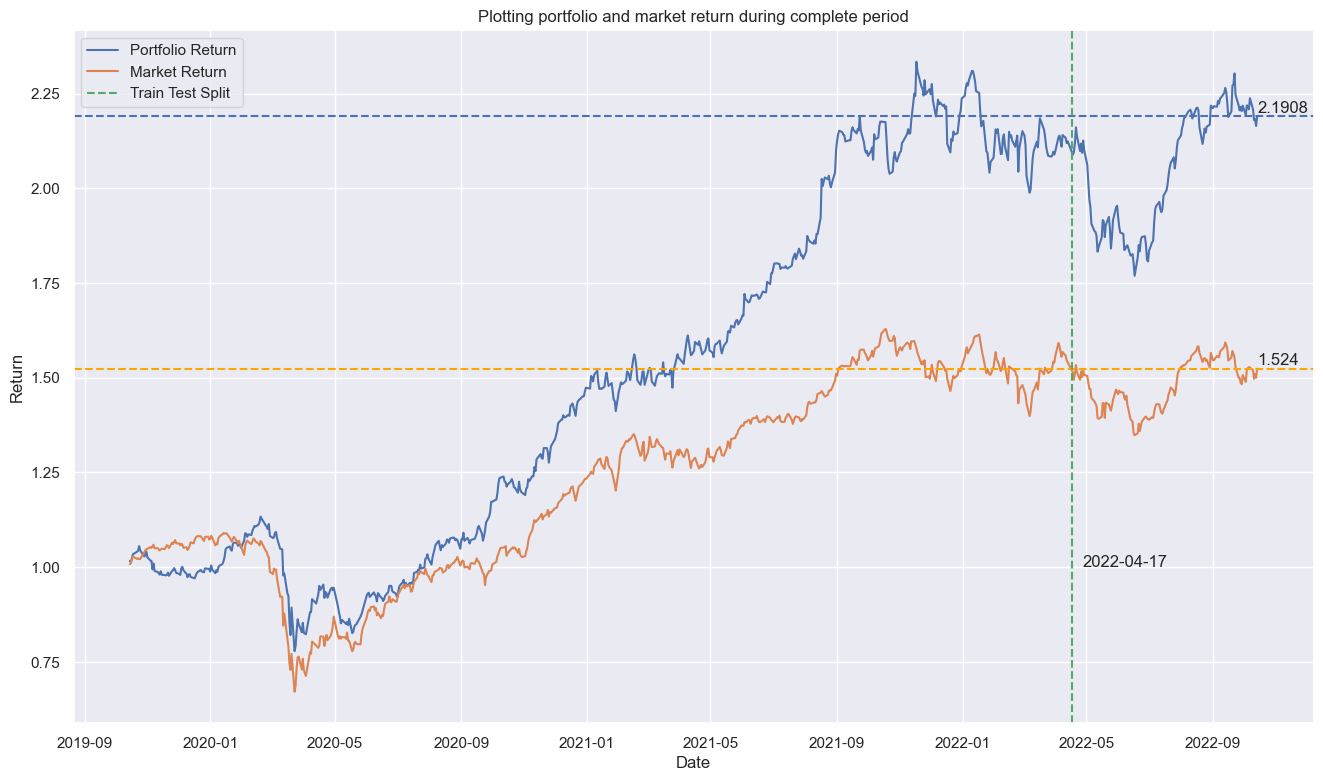

In [159]:
overall_simulation = pd.concat( [train_simulation, test_simulation], ignore_index=True )
overall_simulation['cumprod'] = ( overall_simulation['Return'] + 1 ).cumprod( )
overall_simulation['market_cumprod'] = ( history[index_one]['Return'] + 1 ).cumprod( )

sns.lineplot( data=overall_simulation, x='Date', y='cumprod', label='Portfolio Return' )

sns.lineplot( data=overall_simulation, x = 'Date', y='market_cumprod', label='Market Return' )

plt.axhline( y=float( overall_simulation[-1:]['cumprod'] ), linestyle='--', color='b' )
plt.text( 
            x=overall_simulation['Date'].max( ) - dt.timedelta( days = 0), 
            y=float( overall_simulation[-1:]['cumprod'] ) + 0.01, 
            s=str( round( float( overall_simulation[-1:]['cumprod'] ), 4 ) )
        )

plt.axhline( y=float( overall_simulation[-1:]['market_cumprod'] ), linestyle='--', color='orange' )
plt.text( 
            x=overall_simulation['Date'].max( ) - dt.timedelta( days = 0), 
            y=float( overall_simulation[-1:]['market_cumprod'] ) + 0.01, 
            s=str( round( float( overall_simulation[-1:]['market_cumprod'] ), 4 ) ) 
        )

plt.axvline( x=split_date, linestyle='--', color='g', label='Train Test Split' )
plt.text( x=split_date + dt.timedelta( days = 10), y=1, s=split_date.strftime( '%Y-%m-%d' ) )

plt.ylabel( 'Return' )
plt.legend( )
plt.title( 'Plotting portfolio and market return during complete period' )

plt.show( )

# Calculate Portfolio Beta

In [160]:
portfolio_corr_coeff = np.corrcoef( train_simulation['Return'], train_history[index_one]['Return'] )[0,1] 
portfolio_corr_coeff

0.7631919647133367

In [161]:
portfolio_beta = portfolio_corr_coeff * train_simulation['Return'].std( ) / train_std_return[index_one]
portfolio_beta

0.8007467177912715

In [166]:
weighted_sum_beta = np.dot( efficient_weights, [beta[stock] for stock in chosen_ones] )
weighted_sum_beta

0.8007467177912717

#### Beta of portfolio is equal to the weighted sum of betas of individual stocks